In [ ]:
### TODO:
#   - !!najdi primerni podatkovni bazi za regresijo in klasifikacijo
#   - omogoči naključno rezanje uteži
#   - !!ustvari lažje podajanje hiperparametrov
#   - !!ročno inicializiraj uteži z Gaussian Glorot initialization ALI Gaussian z standard deviation 0.1
#   - !!ustvari lepši ui, ki na boljši način prikaže rezanje in učenje.
#   - podatke kot je early stopping rate, natančnost itd. itd. je treba nekje shraniti in prikazati
#   - !!sproti shranjuj nekatere modele npr. najbolj natančnega, najbolj rezanega ali po vsakem rezanjuž
#   - !!dodaj dve opciji globalno prunanje ali prunanje po sloju
#   - !!izboljšaj early stoppage tako da si shraniš model kot je val večji in ga nato loadaš v primeru če se je učenje prenehalo zaradi early stoppage
#   - v statistiko še dodaj druge metrike kot precision recall in F1
#   - dodaj možnost kjer prunaš samo nekatere uteži npr. samo convolution layerje
#   - !!popravi napako, kjer se zadnja epoha ne pokaže pre early stoppage
#   - Ko šteješ koliko ničel in neničel je štej rajši z maske

### TODO:
#   - probaj densenet brez pretrained uteži
#   - probaj preprečiti rezanje batch norm plasti v densenet
#   - poglej kaki bodo rezultati če znižaš resolucijo slik
#   - probaj znižati learning rate na 1e-5
#   - probaj ročno spremeniti število izhodov za zadnji layer

## NEKAJ JE NAROBE PRI ALEXNET NORMAL WEIGHTS

#POMEMBNO: Za errror pri squeezenet1_1 je kriva glorotova inicializacija uteži

In [1]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchinfo
import matplotlib
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

from neural_network import *
from dataset_realwaste import *
from dataset_chest_xray import *
from iterative_pruning import IterativePruning

#from torchvision.models import squeezenet1_1
#from torchvision.models import densenet121
from torchvision.models import resnet18
from torchvision.models import alexnet

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
NUM_CHANNELS = 1
BATCH_SIZE = 32
NUM_EPOCHS = 100
NUM_PRUNE_ITER = 2
PRUNE_MODE = "global"
PRUNE_PER = 0.2
IMAGE_SIZE = [256,256] #[524, 524] #[28, 28]
LR = 1e-3 #1e-4 #1.2e-3

In [ ]:
## MNIST

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.expand(3, -1, -1)),
])

##pin_memory in num_workers=6

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_subset, val_subset = torch.utils.data.random_split(mnist_trainset, [50000, 10000], generator=torch.Generator().manual_seed(1))

train_loader = DataLoader(dataset=train_subset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_subset, shuffle=False, batch_size=BATCH_SIZE)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
## REALWASTE
real_waste_dataset = RealWasteDataset("./data/realwaste-main/RealWaste", IMAGE_SIZE)

train_size = int(0.7 * len(real_waste_dataset))
val_size = int(0.15 * len(real_waste_dataset))
test_size = len(real_waste_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(real_waste_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(1))

train_loader = DataLoader(dataset = train_dataset, shuffle = True, batch_size = BATCH_SIZE)
val_loader = DataLoader(dataset = val_dataset, shuffle = False, batch_size = BATCH_SIZE)
test_loader = DataLoader(dataset = test_dataset, shuffle = False, batch_size = BATCH_SIZE)


In [4]:
## CHEST XRAY
chest_xray_dataset = ChestXRayDataset("./data/kaggle/kaggle/train3", "./data/train_age.csv", IMAGE_SIZE)

train_size = int(0.7 * len(chest_xray_dataset))
val_size = int(0.15 * len(chest_xray_dataset))
test_size = len(chest_xray_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(chest_xray_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(1))

train_loader = DataLoader(dataset = train_dataset, shuffle = True, batch_size = BATCH_SIZE)
val_loader = DataLoader(dataset = val_dataset, shuffle = False, batch_size = BATCH_SIZE)
test_loader = DataLoader(dataset = test_dataset, shuffle = False, batch_size = BATCH_SIZE)

Velikost učne množice:   7491
Velikost validacijske množice:   1605
Velikost testne množice:   1606
Dimenzija slik: (3, 256, 256)


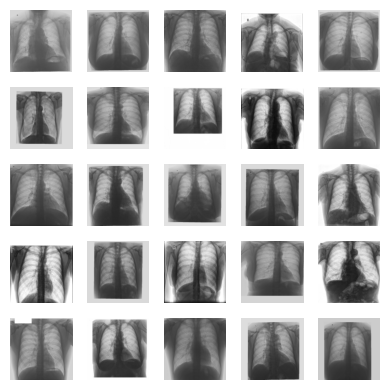

In [5]:
input, targets = next(iter(train_loader))

print(f"Velikost učne množice:   {len(train_dataset)}")
print(f"Velikost validacijske množice:   {len(val_dataset)}")
print(f"Velikost testne množice:   {len(test_dataset)}")
print(f"Dimenzija slik: {input[0].numpy().shape}")

#string_decoded = label_encoder.inverse_transform(targets.ravel())
#print(string_decoded)

dim = int(len(input) ** 0.5)

_, axes = plt.subplots(dim, dim, figsize=(4, 4), squeeze=False)
for i in range(dim):
    for j in range(dim):
        axes[i, j].imshow(input[dim * i + j].numpy().transpose((1,2,0)), cmap="gray")
        axes[i, j].axis("off")
            
plt.tight_layout()

In [6]:
#model = LeNet300(28 * 28, NUM_CHANNELS)

#model = densenet121(weights="IMAGENET1K_V1")

model = resnet18(weights=None)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, NUM_CHANNELS)

#model = alexnet(weights=None)
#num_ftrs = model.classifier[6].in_features
#model.classifier[6] = torch.nn.Linear(num_ftrs, NUM_CHANNELS)


#loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.MSELoss()

## KANALI SO NA RGB
print(torchinfo.summary(model, (BATCH_SIZE, 3, IMAGE_SIZE[0], IMAGE_SIZE[1])))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1]                   --
├─Conv2d: 1-1                            [32, 64, 128, 128]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 128, 128]        128
├─ReLU: 1-3                              [32, 64, 128, 128]        --
├─MaxPool2d: 1-4                         [32, 64, 64, 64]          --
├─Sequential: 1-5                        [32, 64, 64, 64]          --
│    └─BasicBlock: 2-1                   [32, 64, 64, 64]          --
│    │    └─Conv2d: 3-1                  [32, 64, 64, 64]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 64, 64]          128
│    │    └─ReLU: 3-3                    [32, 64, 64, 64]          --
│    │    └─Conv2d: 3-4                  [32, 64, 64, 64]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 64, 64]          128
│    │    └─ReLU: 3-6                    [32, 64, 64, 64]          --
│

In [7]:
ip = IterativePruning(model, apply_weights = True)

ip.start(loss_fn, train_loader, val_loader, test_loader, LR, NUM_EPOCHS , NUM_PRUNE_ITER, PRUNE_MODE, PRUNE_PER, patience = 3, min_delta = 0)

 ===| Prune iteration 1/2 |=== 
Name                              Zeros Nonzeros      All Nonzeros(%)
all                                   1 11172223 11172224     100.00%


Epoch: 8, loss: 67.0407, val_loss: 148.0200 Validating: : 51it [00:04, 11.64it/s]                         
Testing: 51it [00:04, 11.04it/s]                        


MAE: 7.5048
 ===| Prune iteration 2/2 |=== 
Name                              Zeros Nonzeros      All Nonzeros(%)
all                             2233561  8938663 11172224      80.01%


Epoch: 6, loss: 63.5261, val_loss: 138.3650 Validating: : 51it [00:04, 11.56it/s]                        
Testing: 51it [00:04, 11.31it/s]                        

MAE: 7.8068
